# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

Признаки
   - DateCrawled — дата скачивания анкеты из базы
   - VehicleType — тип автомобильного кузова
   - RegistrationYear — год регистрации автомобиля
   - Gearbox — тип коробки передач
   - Power — мощность (л. с.)
   - Model — модель автомобиля
   - Kilometer — пробег (км)
   - RegistrationMonth — месяц регистрации автомобиля
   - FuelType — тип топлива
   - Brand — марка автомобиля
   - NotRepaired — была машина в ремонте или нет
   - DateCreated — дата создания анкеты
   - NumberOfPictures — количество фотографий автомобиля
   - PostalCode — почтовый индекс владельца анкеты (пользователя)
   - LastSeen — дата последней активности пользователя

Целевой признак
   - Price - цена (евро)

## Подготовка данных

## Откроем и изучим файл

Для начала импортируем всё необходимое для выполнения проекта

In [1]:
# теперь для OneHotEncoder работает одновремеено drop='first' и handle_unknown='ignore'
!pip install scikit-learn==1.1.3


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install lightgbm


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# помним про PEP-8
# импорты из стандартной библиотеки
import warnings

# импортируем сторонние библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt


from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from IPython.core.display import display, HTML
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from time import time

# настройки
warnings.filterwarnings("ignore")

C:\Users\Games\AppData\Local\Temp\ipykernel_350028\214380644.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
display(HTML("<style>.container { width:88% !important; }</style>"))

In [5]:
#константы

RANDOM_STATE = 12345
CV = 5 
ITERATIONS = 100
VERBOSE = 1

In [6]:
try:
    forsen = pd.read_csv('/datasets/autos.csv')
except:
    forsen = pd.read_csv('C:/Users/Games/Downloads/autos.csv')

In [7]:
forsen.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
forsen.info(), forsen.shape, display(forsen.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


(None, (354369, 16), None)

In [9]:
def show_na(df):
    na_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([na_info / df.shape[0], na_info], axis=1,  keys=['percent', 'abs'])
           .sort_values('percent', ascending=False))
    res['zero_values'] = (df == 0.00).astype(int).sum(axis=0)
    res['data_type'] = df.dtypes
    res = res[res.iloc[:, 1] != 0]
    return res


show_na(forsen)

,percent,abs,zero_values,data_type
Repaired,0.200791,71154,0,object
VehicleType,0.105794,37490,0,object
FuelType,0.092827,32895,0,object
Gearbox,0.055967,19833,0,object
Model,0.055606,19705,0,object


In [10]:
forsen.duplicated().sum()

4

In [11]:
#Удалим столбцы которые нам не понадобятся
forsen=forsen.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures','RegistrationMonth'], axis=1)
forsen.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [12]:
#Для нашего удобства немного поменяем местами столбцы, чтобы было удобно читать.
column_names = ['Brand','Model','VehicleType','RegistrationYear','Gearbox','Power','FuelType','Kilometer','Repaired', 'Price']
forsen = forsen.reindex(columns=column_names)
#Приведём названия столбцов к нижнему регистру
forsen.columns = forsen.columns.str.lower()
forsen.columns
#Ещё преобразуем названия столбцов, разделив нижним подчеркиванием слова для большей "читабельности".
forsen.columns = ('brand','model','vehicle_type','registration_year','gearbox','power','fuel_type','kilometer','repaired', 'price')
forsen.columns

Index(['brand', 'model', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'fuel_type', 'kilometer', 'repaired', 'price'],
      dtype='object')

In [13]:
forsen.head()

,brand,model,vehicle_type,registration_year,gearbox,power,fuel_type,kilometer,repaired,price
0,volkswagen,golf,NaN,1993,manual,0,petrol,150000,NaN,480
1,audi,NaN,coupe,2011,manual,190,gasoline,125000,yes,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,NaN,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,no,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,no,3600


In [14]:
forsen['repaired'] = forsen['repaired'].fillna('unknown')

show_na(forsen)

,percent,abs,zero_values,data_type
vehicle_type,0.105794,37490,0,object
fuel_type,0.092827,32895,0,object
gearbox,0.055967,19833,0,object
model,0.055606,19705,0,object


До заполнения пропущенных значений в столбцах, уберем аномалии в данных, например строки с годом регистрации ранее 1950 г., или с месяцем регистрации, который равен 0.

In [15]:
f"Количество объявлений с неправильным годом регистрации: {len(forsen.loc[forsen['registration_year'] > 2022])}"

'Количество объявлений с неправильным годом регистрации: 105'

In [16]:
f"Количество объявлений с неправильным годом регистрации: {len(forsen.loc[forsen['registration_year'] < 1950])}"

'Количество объявлений с неправильным годом регистрации: 246'

In [17]:
forsen = forsen.query('1950 <= registration_year <= 2022')

In [18]:
f"Количество объявлений с неправильным годом регистрации: {len(forsen.loc[forsen['registration_year'] > 2022])}"

'Количество объявлений с неправильным годом регистрации: 0'

In [19]:
f"Количество объявлений с неправильным годом регистрации: {len(forsen.loc[forsen['registration_year'] < 1950])}"

'Количество объявлений с неправильным годом регистрации: 0'

Обработали строки с аномальными по нашему мнению значениями в столбце года регистрации авто. Убрали ~0.1% строк от общего числа строк датасета.

Ниже напишем функцию для заполнения пропущенных значений на основе данных из других столбцов, которые присущи тому или иному значению, для него характерному. 

In [20]:
def fill_with_mode(column, column1, column2):
    forsen[column] = forsen.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))
        
#На основе имеющихся данных попробуем заменить пустые значения
fill_with_mode('model','brand','registration_year')
fill_with_mode('vehicle_type','brand','model')
fill_with_mode('fuel_type','brand','model')
fill_with_mode('gearbox','model','brand')
#Заменим Empty на nan и посмотрим, сколько пропусков осталось
forsen = forsen.replace('Empty',np.nan)

In [21]:
show_na(forsen)

,percent,abs,zero_values,data_type
model,0.009316,3298,0,object
gearbox,0.000003,1,0,object


In [22]:
forsen.duplicated().sum()

50486

После всех преобразований у нас осталось некоторое кол-во пропусков (3 299 шт.), в масштабах всего датасета - маленькое, некритично будет их удалить. Также образовалось 50 486 строк совпадающих данных. Они могли отличаться ранее в части убранных нами столбцов. Следовательно, это не реальные дубликаты от которых следовало бы избавиться, а строки с реальным распределением данных по ценообразованию автомобилей.

In [23]:
forsen = forsen.dropna()
forsen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350720 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   brand              350720 non-null  object
 1   model              350720 non-null  object
 2   vehicle_type       350720 non-null  object
 3   registration_year  350720 non-null  int64 
 4   gearbox            350720 non-null  object
 5   power              350720 non-null  int64 
 6   fuel_type          350720 non-null  object
 7   kilometer          350720 non-null  int64 
 8   repaired           350720 non-null  object
 9   price              350720 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.4+ MB


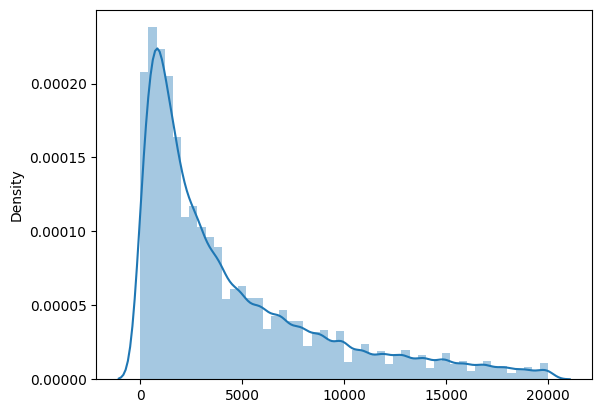

In [24]:
#Посмотрим на распределение целевого признака
sns.distplot(forsen.price.values)
np.median(forsen.price.values)
plt.show()

Пик значений приходится на ~1000 евро за машину. Есть нулевые значения цены, для лучшего обучения моделей удалим их, ибо они некорректны.

In [25]:
f"Количество объявлений с нулевой ценой: {len(forsen.loc[forsen['price'] == 0])}"

'Количество объявлений с нулевой ценой: 10192'

In [26]:
forsen = forsen.query('price != 0')

In [27]:
f"Количество объявлений с нулевой ценой: {len(forsen.loc[forsen['price'] == 0])}"

'Количество объявлений с нулевой ценой: 0'

Удалили ещё прим. 3% строк датасета (10 192 шт.). После этого уберем строки из столбца с мощностью авто с нетипичными и неправдоподобными значениями более тысячи л.с., также нулевые значения заменим на медианное, удалять ещё ~35 тыс. строк с данными не особо хочется.

In [28]:
(forsen['power']>=1000).sum()

280

In [29]:
(forsen['power']==0).sum()

35279

In [30]:
forsen['power'].describe()

count    340528.000000
mean        111.057646
std         187.142550
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [31]:
forsen['power'] = forsen['power'].replace(0, forsen['power'].median())


In [32]:
(forsen['power']==0).sum()

0

In [33]:
#уберем из датасета строки, значения power (мощность машины в л.с.) в которых больше или равны тысяче, т.к. это слишком много для машины, когда среднее значение это 180-200 л.с., а мощнейший автомобиль в мире имеет мощность в 2028 л.с.
#тем более, их всего 298.
forsen = forsen[forsen['power'] < 1000]
forsen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340248 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              340248 non-null  object 
 1   model              340248 non-null  object 
 2   vehicle_type       340248 non-null  object 
 3   registration_year  340248 non-null  int64  
 4   gearbox            340248 non-null  object 
 5   power              340248 non-null  float64
 6   fuel_type          340248 non-null  object 
 7   kilometer          340248 non-null  int64  
 8   repaired           340248 non-null  object 
 9   price              340248 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 28.6+ MB


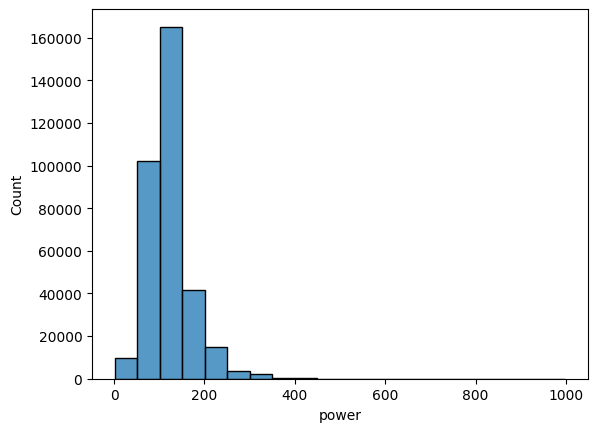

In [34]:
sns.histplot(forsen['power'], bins=20)
plt.show()

Этап предобработки данных завершён, строки с аномальными значениями убраны (чуть более 10% от общего кол-ва строк датасета).

## Подготовим выборки для обучения

In [35]:
X = forsen.drop(['price'], axis=1)
y = forsen['price']

#разделим датасет на обучающую и тестовую выборку размеров 75 на 25
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=RANDOM_STATE)

In [36]:
CAT_FEATURES = ['brand', 'vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']
num_features = ['registration_year', 'power', 'kilometer']

In [37]:
ohe_features_rf = ['brand', 'vehicle_type', 'gearbox', 'fuel_type', 'repaired']
ohe_features_rf

['brand', 'vehicle_type', 'gearbox', 'fuel_type', 'repaired']

In [38]:
CAT_FEATURES

['brand', 'vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']

## Обучим разные модели

**Random Forest Regressor**

In [39]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [40]:
%%time

col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['model']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}

#получается достаточно много комбинаций гиперпараметров при переборе
#будем использовать RandomizedSearchCV, он работает намного быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 1772.1919421037564
best_params: {'randomforestregressor__n_estimators': 150, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 13}
CPU times: total: 12min 43s
Wall time: 1h 49min 6s


**Linear Regression**

In [41]:
#проведём масштабирование численных признаков
scaler = StandardScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [42]:
X.select_dtypes('object').columns

Index(['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'repaired'], dtype='object')

In [43]:
onehotencoder = OneHotEncoder(drop='first', sparse=False).fit(X[CAT_FEATURES])
feature_names = onehotencoder.get_feature_names(CAT_FEATURES)

features_train_ohe = pd.concat([X_train[num_features],  
                                pd.DataFrame(onehotencoder.transform(X_train[CAT_FEATURES]),
                                             columns=feature_names, 
                                             index=X_train.index)], 
                               axis=1)

features_test_ohe = pd.concat([X_test[num_features],  
                                pd.DataFrame(onehotencoder.transform(X_test[CAT_FEATURES]),
                                             columns=feature_names, 
                                             index=X_test.index)], 
                               axis=1)

In [44]:
%%time


lr_model = LinearRegression()

lr_result = cross_val_score(lr_model,
                            features_train_ohe,
                            y_train,
                            cv=CV,
                            scoring='neg_mean_squared_error').mean()

print('RMSE for LinearRegression: ', (-lr_result) ** 0.5)

RMSE for LinearRegression:  2724.682382460965
CPU times: total: 1min 54s
Wall time: 40.4 s


In [45]:
lr_rmse_score = (-lr_result) ** 0.5

**Catboost**

In [46]:
display(CAT_FEATURES)

['brand', 'vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']

In [47]:
def train_model(model, parameters, features, target):
    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=ITERATIONS, 
                                      scoring='neg_root_mean_squared_error', # используем необходимую метрику
                                      cv=CV, 
                                      verbose=VERBOSE, 
                                      random_state=RANDOM_STATE)
    
    # посмотрим время обучения 
    start = time()
    model_random.fit(features, target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))

    # высчитаем метрики
    rmse = model_random.best_score_ * -1
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    
    return model_random, rmse



In [48]:
parameters = {'depth': [6, 8, 10],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'iterations': [100, 200, 400]
              }

cat = CatBoostRegressor(verbose=False, task_type='GPU', cat_features=CAT_FEATURES) # у меня мощная видеокарта и она с ней обучалась куда быстрее

cat_random, rmse_cat = train_model(cat, parameters, X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomizedSearchCV подбирал параметры 1775.98 секунд
Лучшие параметры: {'learning_rate': 0.1, 'iterations': 400, 'depth': 10}
RMSE обученной модели: 1620.820658964898


**LightGBM**

Сделаем копию тренировочных признаков и преобразуем их в категориальный тип для корректной работы данной модели. 

In [49]:
X_train_categorical = X_train.copy()

for column in X_train_categorical.columns:
    col_type = X_train_categorical[column].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_train_categorical[column] = X_train_categorical[column].astype('category')

X_test_categorical = X_test.copy()

for column in X_test_categorical.columns:
    col_type = X_test_categorical[column].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test_categorical[column] = X_test_categorical[column].astype('category')

In [50]:
X_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255186 entries, 174757 to 226692
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   brand              255186 non-null  category
 1   model              255186 non-null  category
 2   vehicle_type       255186 non-null  category
 3   registration_year  255186 non-null  float64 
 4   gearbox            255186 non-null  category
 5   power              255186 non-null  float64 
 6   fuel_type          255186 non-null  category
 7   kilometer          255186 non-null  float64 
 8   repaired           255186 non-null  category
dtypes: category(6), float64(3)
memory usage: 9.5 MB


In [51]:
%%time

rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25],
    'learning_rate': [0.01, 0.1, 0.15],
    'num_leaves': [10, 50, 100]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random, rmse_gbm = train_model(gbm, rand_lgbm_param, X_train_categorical, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 204148, number of used features: 9
[LightGBM] [Info] Start training from score 4553.486231
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 204149, number of used features: 9
[LightGBM] [Info] Start training from score 4541.497470
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003997 seconds.
You can s

## Анализ моделей

In [52]:
result = pd.DataFrame(
    [gs_rf_best_score, lr_rmse_score, rmse_cat, rmse_gbm], 
    index=['RandomForestRegressor', 'LinearRegression', 'Catboost', 'LGBM'], 
    columns=['RMSE']
)
result

,RMSE
RandomForestRegressor,1772.191942
LinearRegression,2724.682382
Catboost,1620.820659
LGBM,1599.796465


Модель случайного леса очень долго подбирает гиперпараметры и обучается. RMSE модели - 1772. Линейной регрессии на это потребовалось лишь ~40 секунд, но метрика RMSE наихудшая из представленных - 2725. Catboost потребовалось на перебор гиперпараметров и обучение ~13 минут, уже лучше, но не то. RMSE - 1621. LightGBM справилась в 6 раз быстрее, ~2 минуты. Метрика RMSE наилучшая как раз-таки у LightGBM - 1600. Далее проверим её качество на тестовой выборке.

In [53]:
%%time

gbm_prediction = gbm_random.predict(X_test_categorical)
metric_test = mean_squared_error(y_test, gbm_prediction, squared=False)
metric_test

CPU times: total: 1.09 s
Wall time: 160 ms


1606.4874635712545

В итоге на тестовой выборке RMSE наилучшей модели 1606, время предсказания 0.2 сек.